In [65]:
import pandas as pd
from glob import glob
import re
import math
import numpy as np
import torch
import torchvision
import scipy.ndimage
import cv2

from pathlib import Path

In [66]:
speed = pd.read_json('full_on_pwc/loi_speed_vids.json')
speed['vid'] = speed['i']
del speed['i']
speed

,mean_orig,mean_5,sum_5,mean_10,sum_10,vid
0,3.836065,4.362258,0.226903,5.237803,0.182673,0
1,0.877665,2.789844,0.297556,3.929664,0.192305,1
2,4.605023,6.154173,0.159889,9.050204,0.104100,2
3,3.999288,8.590240,0.112917,10.888792,0.087461,3
4,5.552701,8.591812,0.114213,12.959874,0.073496,4
5,3.077326,11.151953,0.085875,13.940630,0.067793,5
6,7.489698,7.665483,0.130321,8.023465,0.123893,6
7,4.590495,7.336521,0.133405,10.021151,0.094930,7
8,4.768394,5.456762,0.181739,6.392471,0.151646,8
9,5.917674,6.852472,0.144879,8.809222,0.109680,9


In [67]:
info = []
for file in glob('full_on_pwc/loi_results/*'):
    sf = Path(file).stem.split('_')
    print("Load {}".format(file))
    l = pd.read_json(file)
    l['level'] = sf[0]
    l['version'] = sf[1]
    l['width'] = int(sf[2])
    
    if len(sf) > 3 and sf[1] == 'v2':
        l['height_times'] = float(sf[3])
    elif sf[1] == 'v2':
        l['height_times'] = 2.0
    else:
        l['height_times'] = 0.0
    info.append(l)
    
print("Total files loaded: {}".format(len(info)))
    
info = pd.concat(info)

Load full_on_pwc/loi_results/region_v1_70_2.0.json
Load full_on_pwc/loi_results/region_v4_30_2.0.json
Load full_on_pwc/loi_results/region_v2_100_1.5.json
Load full_on_pwc/loi_results/region_v2_100_2.0.json
Load full_on_pwc/loi_results/pixel_v1_10_2.0.json
Load full_on_pwc/loi_results/region_v1_140_2.0.json
Load full_on_pwc/loi_results/region_v4_100_2.0.json
Load full_on_pwc/loi_results/region_v2_40_1.0.json
Load full_on_pwc/loi_results/region_v2_20.json
Load full_on_pwc/loi_results/region_v4.7_80_2.0.json
Load full_on_pwc/loi_results/pixel_v1_70_2.0.json
Load full_on_pwc/loi_results/region_v4.7_100_2.0.json
Load full_on_pwc/loi_results/region_v2_100_3.0.json
Load full_on_pwc/loi_results/region_v1_20.json
Load full_on_pwc/loi_results/region_v4.7_90_2.0.json
Load full_on_pwc/loi_results/region_v1_140_1.5.json
Load full_on_pwc/loi_results/region_v2_70_1.0.json
Load full_on_pwc/loi_results/region_v2_40.json
Load full_on_pwc/loi_results/region_v4.7_60_2.0.json
Load full_on_pwc/loi_results/r

In [68]:
r = pd.merge(info, speed, how='left', on=['vid'])
r

,vid,loi,mae,mse,ptmae,rmae,level,version,width,height_times,mean_orig,mean_5,sum_5,mean_10,sum_10
0,0,0,2.644128,5.511522,0.118624,0.881376,region,v1,70,0.0,3.836065,4.362258,0.226903,5.237803,0.182673
1,0,1,2.754582,4.634821,0.311354,0.688646,region,v1,70,0.0,3.836065,4.362258,0.226903,5.237803,0.182673
2,0,2,1.217599,56.472944,0.797067,0.202933,region,v1,70,0.0,3.836065,4.362258,0.226903,5.237803,0.182673
3,0,3,2.078645,18.205864,0.528787,0.692882,region,v1,70,0.0,3.836065,4.362258,0.226903,5.237803,0.182673
4,0,4,4.417338,72.583843,0.368952,0.631048,region,v1,70,0.0,3.836065,4.362258,0.226903,5.237803,0.182673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,18,0,0.930357,2.553914,0.534821,0.465179,region,v2,20,3.0,1.421665,2.386691,0.380179,5.393789,0.135744
1516,18,1,1.287403,1.519852,0.412144,0.643701,region,v2,20,3.0,1.421665,2.386691,0.380179,5.393789,0.135744
1517,19,0,1.846888,67.362860,0.652301,0.369378,region,v2,20,3.0,10.411788,13.323588,0.074595,16.582186,0.059269
1518,19,1,7.024053,357.867566,0.531730,0.468270,region,v2,20,3.0,10.411788,13.323588,0.074595,16.582186,0.059269


In [69]:
r.groupby(['level', 'version', 'width', 'height_times']).mean()

vid    loi       mae        mse  \
level  version width height_times                                      
pixel  v1      10    0.0           8.825  0.725  3.247130  41.212039   
               20    0.0           8.825  0.725  3.218737  42.904933   
               40    0.0           8.825  0.725  3.230033  43.321209   
               70    0.0           8.825  0.725  3.363491  44.145266   
               100   0.0           8.825  0.725  3.349697  44.698370   
region v1      10    0.0           8.825  0.725  3.587773  40.922191   
               20    0.0           8.825  0.725  3.299438  42.891001   
               40    0.0           8.825  0.725  3.176073  43.542675   
               70    0.0           8.825  0.725  3.165198  43.655574   
               100   0.0           8.825  0.725  3.113308  44.717117   
               140   0.0           8.825  0.725  3.259370  44.071229   
       v2      20    2.0           8.825  0.725  3.331619  42.279264   
                     3.0           8.825  0.725  3.286961  43.031828   
               40    1.0           8.825  0.725  3.217718  43.195321   
                     1.5           8.825  0.725  3.208922  44.633517   
                     2.0           8.825  0.725  3.081488  43.858490   
                     3.0           8.825  0.725  3.279866  46.685588   
               70    1.0           8.825  0.725  3.243202  46.196140   
                     1.5           8.825  0.725  3.063816  44.926226   
                     2.0           8.825  0.725  3.014103  43.150863   
                     3.0           8.825  0.725  3.065144  47.499116   
               100   1.0           8.825  0.725  3.062553  45.493933   
                     1.5           8.825  0.725  2.985491  44.919777   
                     2.0           8.825  0.725  3.052381  47.951796   
                     3.0           8.825  0.725  3.116325  43.481987   
               140   2.0           8.825  0.725  3.240636  43.730831   
       v4      30    0.0           8.825  0.725  3.294139  45.218482   
               40    0.0           8.825  0.725  3.318195  45.901686   
               60    0.0           8.825  0.725  3.255399  45.970365   
               80    0.0           8.825  0.725  3.044584  44.817688   
               100   0.0           8.825  0.725  3.124266  48.178019   
       v4.7    60    0.0           8.825  0.725  3.035024  45.118892   
               70    0.0           8.825  0.725  2.988186  44.828685   
               80    0.0           8.825  0.725  3.188634  48.447726   
               90    0.0           8.825  0.725  3.370654  47.787669   
               100   0.0           8.825  0.725  3.370708  47.389516   

                                      ptmae      rmae  mean_orig    mean_5  \
level  version width height_times                                            
pixel  v1      10    0.0           0.529003  0.553054   4.282316  7.159454   
               20    0.0           0.533752  0.534005   4.282316  7.159454   
               40    0.0           0.517932  0.526007   4.282316  7.159454   
               70    0.0           0.515636  0.562646   4.282316  7.159454   
               100   0.0           0.511161  0.566500   4.282316  7.159454   
region v1      10    0.0           0.468496  0.587775   4.282316  7.159454   
               20    0.0           0.517466  0.531933   4.282316  7.159454   
               40    0.0           0.530660  0.511510   4.282316  7.159454   
               70    0.0           0.541921  0.530880   4.282316  7.159454   
               100   0.0           0.537764  0.526945   4.282316  7.159454   
               140   0.0           0.522235  0.551664   4.282316  7.159454   
       v2      20    2.0           0.495142  0.549200   4.282316  7.159454   
                     3.0           0.511319  0.537442   4.282316  7.159454   
               40    1.0           0.510660  0.523898   4.282316  7.159454   
                     1.5           0.522187  0.51397

In [51]:
f = r.groupby(['level', 'version', 'width', 'height_times', 'vid']).mean().reset_index()

In [28]:
print("When per vid optimally is predicted predicts")
f.groupby(['vid']).min().mean()

When per vid optimally is predicted predicts


width           10.000000
height_times     0.000000
loi              0.500000
mae              2.583219
mse             32.941813
ptmae            0.389716
rmae             0.425105
mean_orig        4.063572
mean_5           6.893478
sum_5            0.193591
mean_10          9.050899
sum_10           0.129138
dtype: float64

In [54]:
sel = r[r['version'] == 'v2']
t = r.iloc[sel.groupby(['vid','loi']).idxmin()['rmae']].reset_index()
# t['sel_rmae'] = sel.groupby('vid').mean().reset_index()['rmae'] - t['rmae']
# t['sel_mae'] = sel.groupby('vid').mean().reset_index()['mae'] - t['mae']
# t['wb_rmae'] = f.groupby('vid').mean().reset_index()['rmae'] - t['rmae']
# t['wb_mae'] = f.groupby('vid').mean().reset_index()['mae'] - t['mae']

# t['width_speed'] = t['width'] / t['mean_10']
# t['height_speed'] = t['height_times'] / t['mean_10']



In [55]:
t

,index,vid,loi,mae,mse,ptmae,rmae,level,version,width,height_times,mean_orig,mean_5,sum_5,mean_10,sum_10
0,1120,0,0,2.362601,6.683944,0.212466,0.787534,region,v2,140,2.0,3.836065,4.362258,0.226903,5.237803,0.182673
1,961,0,1,2.743643,4.649739,0.314089,0.685911,region,v2,70,2.0,3.836065,4.362258,0.226903,5.237803,0.182673
2,602,0,2,0.506324,64.380142,0.918363,0.084387,region,v2,40,3.0,3.836065,4.362258,0.226903,5.237803,0.182673
3,563,0,3,1.299125,22.638050,0.604780,0.433042,region,v2,40,2.0,3.836065,4.362258,0.226903,5.237803,0.182673
4,404,0,4,2.460893,105.002725,0.648444,0.351556,region,v2,100,3.0,3.836065,4.362258,0.226903,5.237803,0.182673
5,1205,1,0,2.065559,41.316922,0.586888,0.413112,region,v2,100,1.0,0.877665,2.789844,0.297556,3.929664,0.192305
6,1166,2,0,2.897679,85.091340,0.557513,0.482946,region,v2,70,3.0,4.605023,6.154173,0.159889,9.050204,0.104100
7,1167,2,1,2.936553,212.265683,0.706345,0.293655,region,v2,70,3.0,4.605023,6.154173,0.159889,9.050204,0.104100
8,968,3,0,1.823816,3.025039,0.669923,0.364763,region,v2,70,2.0,3.999288,8.590240,0.112917,10.888792,0.087461
9,1169,3,1,1.031483,0.954883,0.770080,0.257871,region,v2,70,3.0,3.999288,8.590240,0.112917,10.888792,0.087461


In [60]:
t.mean()

index           752.500000
vid               8.825000
loi               0.725000
mae               2.439225
mse              47.299940
ptmae             0.620935
rmae              0.402111
width            68.750000
height_times      2.075000
mean_orig         4.282316
mean_5            7.159454
sum_5             0.187156
mean_10           9.251550
sum_10            0.129045
dtype: float64

In [61]:
sel.groupby(['vid', 'width']).mean()

loi       mae         mse     ptmae      rmae  height_times  \
vid width                                                                
0   20     2.0  2.849378   27.691822  0.368830  0.636824         2.500   
    40     2.0  2.702960   29.424691  0.396594  0.611304         1.875   
    70     2.0  2.638561   31.173162  0.418893  0.623368         1.875   
    100    2.0  2.389803   36.089529  0.465498  0.586056         1.875   
    140    2.0  2.501635   33.625049  0.454179  0.595331         2.000   
...        ...       ...         ...       ...       ...           ...   
19  20     1.0  5.118096  174.877369  0.484295  0.551616         2.500   
    40     1.0  5.141070  170.240352  0.507556  0.549774         1.875   
    70     1.0  5.035768  166.768993  0.516217  0.543556         1.875   
    100    1.0  4.944175  167.904975  0.520819  0.544510         1.875   
    140    1.0  5.379326  158.363565  0.486728  0.606724         2.000   

           mean_orig     mean_5     sum_5    mean_10    sum_10  
vid width                                                       
0   20      3.836065   4.362258  0.226903   5.237803  0.182673  
    40      3.836065   4.362258  0.226903   5.237803  0.182673  
    70      3.836065   4.362258  0.226903   5.237803  0.182673  
    100     3.836065   4.362258  0.226903   5.237803  0.182673  
    140     3.836065   4.362258  0.226903   5.237803  0.182673  
...              ...        ...       ...        ...       ...  
19  20     10.411788  13.323588  0.074595  16.582186  0.059269  
    40     10.411788  13.323588  0.074595  16.582186  0.059269  
    70     10.411788  13.323588  0.074595  16.582186  0.059269  
    100    10.411788  13.323588  0.074595  16.582186  0.059269  
    140    10.411788  13.323588  0.074595  16.582186  0.059269  

[100 rows x 11 columns]

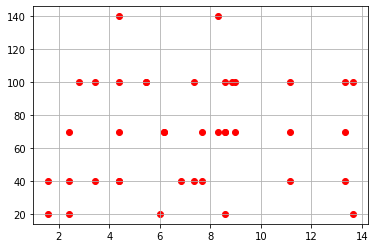

In [64]:
import matplotlib.pyplot as plt
plt.scatter(t['mean_10'], t['width'], color='red')
# plt.title('Stock Index Price Vs Interest Rate', fontsize=14)
# plt.xlabel('Interest Rate', fontsize=14)
# plt.ylabel('Stock Index Price', fontsize=14)
plt.grid(True)
plt.show()